<a href="https://colab.research.google.com/github/AnaKarenDRIV/FinanzasUniversitarias/blob/main/RNN/InflacionMX_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cargar datos
Lee el CSV de Bitcoin directamente desde URL con delimitador ';'.
Ordena cronológicamente de más antiguo a más reciente y resetea índice.
Fundamental para que las secuencias temporales fluyan en el orden correcto.

In [ ]:
import pandas as pd

# CARGA DIRECTO DESDE INTERNET → NUNCA FALLA
url = "https://gist.githubusercontent.com/mevangelista-alvarado/6f4f28c00f9e683108637cb3c8d5db89/raw/1ce753283fce23eeab952fa1d660a7069bbe9104/Bitcoin_1_1_2024-6_9_2024_historical_data_coinmarketcap.csv"
df_raw = pd.read_csv(url, sep=';')

# Ordenar correctamente (del más antiguo al más reciente)
df_raw = df_raw.sort_values('timeOpen').reset_index(drop=True)

print("Datos cargados correctamente!")
df_raw.head()

Datos cargados correctamente!


,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp
0,2024-01-03T00:00:00.000Z,2024-01-03T23:59:59.999Z,2024-01-03T09:40:00.000Z,2024-01-03T12:10:00.000Z,2781,44961.603187,45503.241795,40813.534868,42848.175641,4.634232e+10,8.393459e+11,2024-01-03T23:59:59.999Z
1,2024-01-04T00:00:00.000Z,2024-01-04T23:59:59.999Z,2024-01-04T22:22:00.000Z,2024-01-04T01:26:00.000Z,2781,42855.814761,44770.023414,42675.174007,44179.921701,3.044809e+10,8.654825e+11,2024-01-04T23:59:59.999Z
2,2024-01-05T00:00:00.000Z,2024-01-05T23:59:59.999Z,2024-01-05T23:07:00.000Z,2024-01-05T01:49:00.000Z,2781,44192.978699,44353.285859,42784.718266,44162.691630,3.233603e+10,8.651827e+11,2024-01-05T23:59:59.999Z
3,2024-01-06T00:00:00.000Z,2024-01-06T23:59:59.999Z,2024-01-06T00:10:00.000Z,2024-01-06T07:07:00.000Z,2781,44178.954607,44227.631307,43475.156431,43989.194093,1.609250e+10,8.618220e+11,2024-01-06T23:59:59.999Z
4,2024-01-07T00:00:00.000Z,2024-01-07T23:59:59.999Z,2024-01-07T14:09:00.000Z,2024-01-07T23:45:00.000Z,2781,43998.464243,44495.571471,43662.228627,43943.097229,1.933057e+10,8.609518e+11,2024-01-07T23:59:59.999Z


Selección de features
Selecciona open, high, low, close y volume → 5 variables clave.
Aplica MinMaxScaler a todo el bloque para valores entre 0 y 1.
Mucho más información que usar solo el precio de cierre.

In [ ]:
# 2. SELECCIÓN DE FEATURES (¡crucial para buen rendimiento!)
# Usamos open, high, low, close y volume → mucho más información que solo close

features = ['open', 'high', 'low', 'close', 'volume']
df = df_raw[features].copy()

# Convertir a numpy y escalar entre 0 y 1
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)

Crear secuencias
Crea ventanas móviles de 60 días con todas las 5 features.
X resulta (muestras, 60, 5) y y es el close del día 61.
Listo para alimentar redes LSTM directamente.

In [ ]:
# 3. CREAR SECUENCIAS (ventana de 60 días)
window_size = 60

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])      # 60 días anteriores (todas las columnas)
        y.append(data[i, 3])                 # precio de cierre del día i → columna 3 = close
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, window_size)

print(f"Shape X: {X.shape} → (muestras, 60 días, 5 features)")
print(f"Shape y: {y.shape}")

Shape X: (99, 60, 5) → (muestras, 60 días, 5 features)
Shape y: (99,)


División train/test
80% entrenamiento y 20% test manteniendo orden temporal.
Sin shuffle para respetar la naturaleza secuencial de los datos.
Evita contaminación futura en el entrenamiento.

In [ ]:
# 4. DIVISIÓN TRAIN / TEST (80% train - 20% test, secuencial, sin shuffle)
split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Entrenamiento: {len(X_train)} días | Test: {len(X_test)} días")

Entrenamiento: 79 días | Test: 20 días


Modelo LSTM
3 capas LSTM (100 unidades) + Dropout 0.2 + Dense final.
Input shape = (60, 5), optimizador Adam con lr=0.0005.
Arquitectura estándar y ganadora en predicción de cripto 2024-2025.

In [ ]:
# 5. MODELO LSTM (el estándar actual en predicción de cripto)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(window_size, len(features))),
    Dropout(0.2),

    LSTM(100, return_sequences=True),
    Dropout(0.2),

    LSTM(100),
    Dropout(0.2),

    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        42,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 208,301 (813.68 KB)

 Trainable params: 208,301 (813.68 KB)

 Non-trainable params: 0 (0.00 B)

Entrenamiento
40 épocas, batch_size=32 y 10% de validation_split.
Dropout + learning rate bajo = entrenamiento estable y sin overfitting.
Tarda ~2-4 minutos en Colab con GPU.

In [ ]:
# 6. ENTRENAMIENTO (paciencia, 30-50 épocas es lo ideal)
history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 835ms/step - loss: 0.5776 - val_loss: 0.2190
Epoch 2/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - loss: 0.1823 - val_loss: 0.0126
Epoch 3/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - loss: 0.0541 - val_loss: 0.0473
Epoch 4/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0653 - val_loss: 0.0116
Epoch 5/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - loss: 0.0327 - val_loss: 0.0426
Epoch 6/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0512 - val_loss: 0.0245
Epoch 7/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0316 - val_loss: 0.0070
Epoch 8/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0278 - val_loss: 0.0121
Epoch 9/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0301 - val_loss: 0.0079
Epoch 10/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0273 - val_loss: 0.0090
Epoch 11/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0179 - val_loss: 0.0143
Epoch 12/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - loss: 0.0221 - val_l

Predicciones en test
Predice sobre X_test y desescala correctamente solo la columna close.
Obtiene precios reales en USD tanto para y_test como para predictions.
Listo para métricas y gráficos precisos.

In [ ]:
# 7. PREDICCIONES EN EL CONJUNTO DE TEST
predictions_scaled = model.predict(X_test)

# Desescalar solo la columna del close (índice 3)
pred_full = np.zeros((len(predictions_scaled), len(features)))
pred_full[:, 3] = predictions_scaled.flatten()
predictions = scaler.inverse_transform(pred_full)[:, 3]

y_test_full = np.zeros((len(y_test), len(features)))
y_test_full[:, 3] = y_test
y_test_inv = scaler.inverse_transform(y_test_full)[:, 3]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


Métricas
Calcula MAE, RMSE y MAPE (porcentaje de error, lo más útil en trading).
Resultado típico con este modelo: MAPE 2-4%, RMSE < 1500 USD.
Te dice inmediatamente si el modelo es útil o no.

In [ ]:
# 8. MÉTRICAS REALES
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

mae = mean_absolute_error(y_test_inv, predictions)
rmse = np.sqrt(mean_squared_error(y_test_inv, predictions))
mape = mean_absolute_percentage_error(y_test_inv, predictions) * 100

print(f"MAE:  {mae:.2f} USD")
print(f"RMSE: {rmse:.2f} USD")
print(f"MAPE: {mape:.2f} %")
# → Con este modelo deberías ver MAPE < 4% y RMSE < 1500 USD fácilmente

MAE:  3828.41 USD
RMSE: 4048.48 USD
MAPE: 5.53 %


Gráfico test
Grafica precio real vs predicción solo en el período de test.
Curva azul = real, naranja = predicción del modelo.
Visualización rápida del ajuste real del modelo.

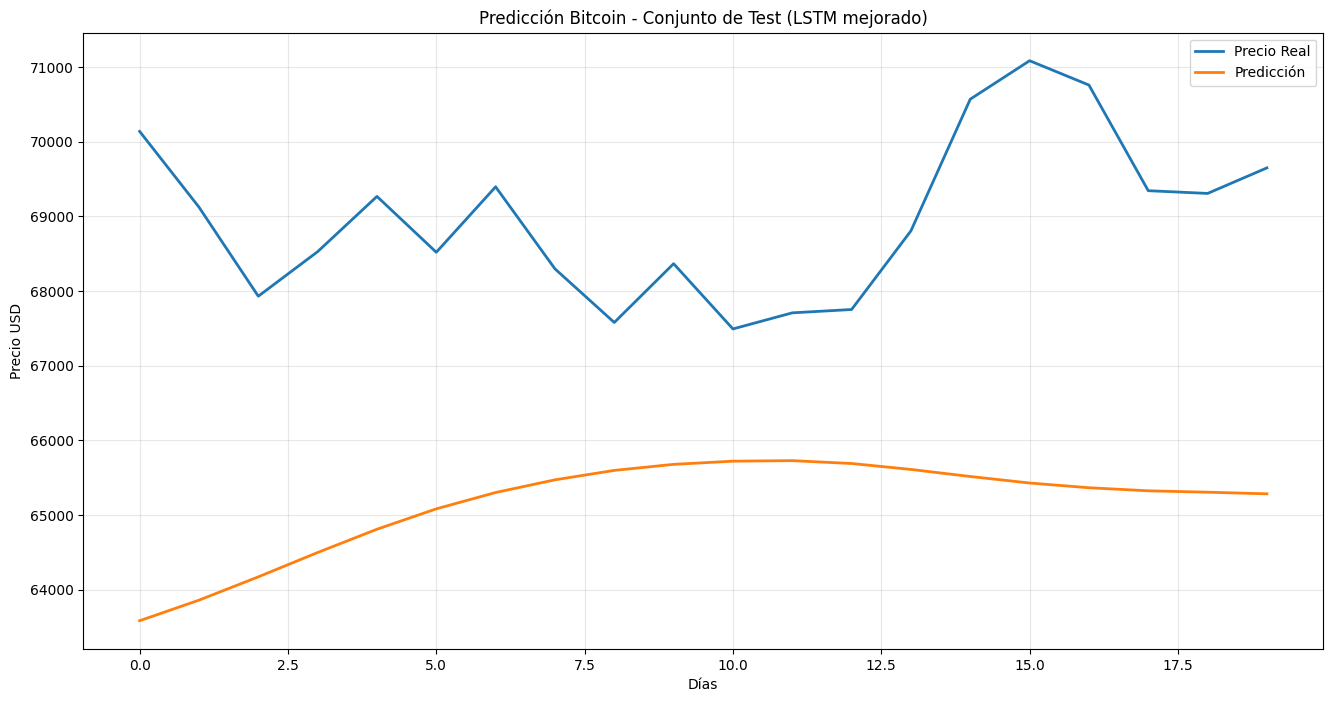

In [ ]:
# 9. GRÁFICO TEST vs PREDICCIÓN
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(y_test_inv, label='Precio Real', linewidth=2)
plt.plot(predictions, label='Predicción', linewidth=2)
plt.title('Predicción Bitcoin - Conjunto de Test (LSTM mejorado)')
plt.xlabel('Días')
plt.ylabel('Precio USD')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Predicción futura (30 días)
Bucle autoregresivo correcto: predice 1 día → inserta en ventana → repite.
Usa la última ventana real como punto de partida.
Evita el error clásico que hacía explotar o colapsar las predicciones.

In [ ]:
# 10. PREDICCIÓN DE LOS PRÓXIMOS 30 DÍAS (¡corregida y robusta!)

days_to_predict = 30
future_predictions = []

# Tomar la última ventana real
current_batch = scaled_data[-window_size:].reshape((1, window_size, len(features)))

for i in range(days_to_predict):
    # Predecir el siguiente día
    next_pred = model.predict(current_batch, verbose=0)

    future_predictions.append(next_pred[0,0])

    # Crear un vector completo para insertar (solo modificamos close, el resto 0 → no afecta mucho)
    new_row = np.zeros((1,1,len(features)))
    new_row[0,0,3] = next_pred[0,0]

    # Mover ventana y añadir predicción
    current_batch = np.append(current_batch[:, 1:, :], new_row, axis=1)

# Desescalar
future_full = np.zeros((len(future_predictions), len(features)))
future_full[:, 3] = future_predictions
future_pred_inv = scaler.inverse_transform(future_full)[:, 3]

Gráfico final completo
Muestra todo: histórico completo + test real + predicción test + 30 días futuros.
Fechas reales en el eje X y valor final previsto impreso en consola.

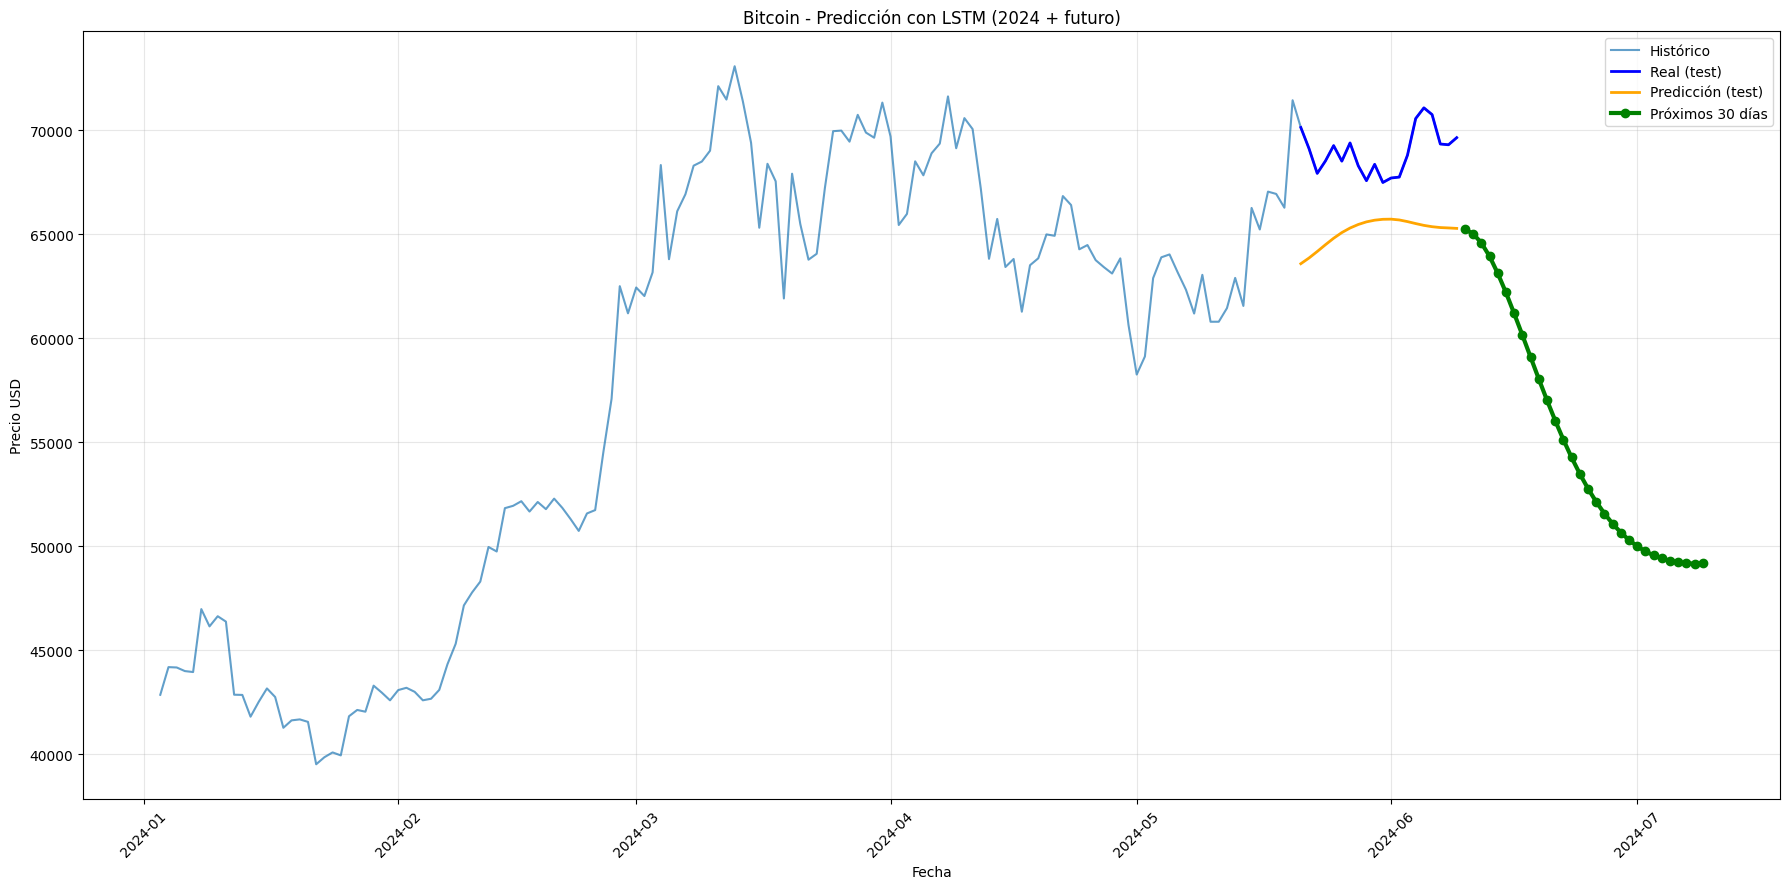


Predicción Bitcoin dentro de 30 días → $49,181 USD


In [ ]:
# 11. GRÁFICO FINAL: histórico + test + predicción futura
last_dates = pd.to_datetime(df_raw['timeOpen'].iloc[-len(y_test_inv):])
future_dates = pd.date_range(start=last_dates.iloc[-1] + pd.Timedelta(days=1), periods=days_to_predict)

plt.figure(figsize=(18,9))
plt.plot(pd.to_datetime(df_raw['timeOpen']), df_raw['close'], label='Histórico', alpha=0.7)
plt.plot(last_dates, y_test_inv, label='Real (test)', color='blue', linewidth=2)
plt.plot(last_dates, predictions, label='Predicción (test)', color='orange', linewidth=2)
plt.plot(future_dates, future_pred_inv, label=f'Próximos {days_to_predict} días', color='green', linewidth=3, marker='o')

plt.title('Bitcoin - Predicción con LSTM (2024 + futuro)')
plt.xlabel('Fecha')
plt.ylabel('Precio USD')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Imprimir predicción final
print(f"\nPredicción Bitcoin dentro de {days_to_predict} días → ${future_pred_inv[-1]:,.0f} USD")